<a href="https://colab.research.google.com/github/MinabutdinovAlmaz/MlPython/blob/main/MinabutdinovAA_4405_lab7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Сегментация MNIST на простой U-Net

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Загрузка данных (пример с использованием синтетических данных)
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Нормализация данных
x_train = x_train / 255.0
x_test = x_test / 255.0
y_train = y_train / 255.0
y_test = y_test / 255.0

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
print(y_test)

[0.02745098 0.00784314 0.00392157 ... 0.01568627 0.01960784 0.02352941]


In [ ]:
# Создаем бинарные маски для каждого изображения
# если значение пикселя > 0.6, то считаем что это цифра и закрашиваем
# пиксель в маске, где цифра — 1, фон — 0
y_train_masks = np.where(x_train > 0.6, 1, 0).astype(np.float32)
y_test_masks = np.where(x_test > 0.6, 1, 0).astype(np.float32)


In [ ]:
print(y_test_masks)

[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]


In [ ]:
#debug
i = 1000 #номер цифры из массива (всего от 0 до 59999)
print("Shape of x_train:", x_train.shape)
print("Shape of x_test:", x_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)
print("Shape of y_train masks:", y_train_masks.shape)
print("Shape of y_test masks:", y_test_masks.shape)
#print("Example mask:\n", y_train_masks[0,:,:,:])

Shape of x_train: (60000, 28, 28)
Shape of x_test: (10000, 28, 28)
Shape of y_train: (60000,)
Shape of y_test: (10000,)
Shape of y_train masks: (60000, 28, 28)
Shape of y_test masks: (10000, 28, 28)


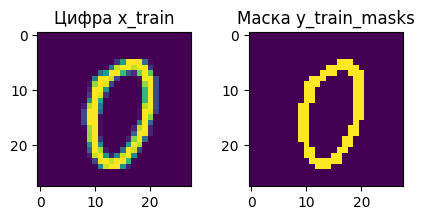

In [ ]:
fig = plt.figure(figsize=(5, 2))
plt.subplot(1,2,1)
plt.imshow(x_train[i, :, :])#, 0])
plt.title("Цифра x_train")
plt.subplot(1,2,2)
plt.imshow(y_train_masks[i, :, :])#, 0])#, cmap='gray')
plt.title("Маска y_train_masks")
plt.show()

In [ ]:
# Создание модели U-Net
def unet_model(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Downsample
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    pool1 = layers.MaxPooling2D((2, 2))(conv1)

    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = layers.MaxPooling2D((2, 2))(conv2)

    # Upsample
    up1 = layers.UpSampling2D((2, 2))(pool2)
    concat1 = layers.concatenate([up1, conv2], axis=-1)
    conv3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(concat1)

    up2 = layers.UpSampling2D((2, 2))(conv3)
    concat2 = layers.concatenate([up2, conv1], axis=-1)
    conv4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(concat2)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(conv4)

    model = models.Model(inputs, outputs)
    return model

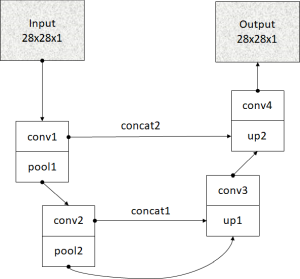

In [ ]:
# Создание и компиляция модели
model = unet_model((28, 28, 1))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Обучение модели
model.fit(x_train[..., np.newaxis], y_train_masks, epochs=5, validation_data=(x_test[..., np.newaxis], y_test_masks))

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 25s 10ms/step - accuracy: 0.9894 - loss: 0.0282 - val_accuracy: 0.9990 - val_loss: 0.0026
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 35s 9ms/step - accuracy: 0.9990 - loss: 0.0024 - val_accuracy: 0.9993 - val_loss: 0.0017
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.9993 - loss: 0.0017 - val_accuracy: 0.9996 - val_loss: 0.0012
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.9995 - loss: 0.0013 - val_accuracy: 0.9995 - val_loss: 0.0012
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.9996 - loss: 0.0010 - val_accuracy: 0.9997 - val_loss: 7.4744e-04


In [ ]:
# Оценка модели
test_loss, test_acc = model.evaluate(x_test[..., np.newaxis], y_test_masks)
print(f"Точность на тестовых данных: {test_acc}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9997 - loss: 7.5866e-04
Точность на тестовых данных: 0.9997403025627136


In [ ]:
# Функция для визуализации результатов
def visualize_segmentation(model, x_test, true_labels, num_images=5):
    predicted_labels = predictions[:,:,:,0]

    plt.figure(figsize=(15, 3 * num_images))
    for i in range(num_images):
        #генерация случайного индекса цифры из набора
        index = np.random.randint(0, len(x_test))

        # Оригинальное изображение
        plt.subplot(num_images, 3, 3 * i + 1)
        plt.imshow(x_test[index], cmap='gray')
        plt.title("Оригинал")
        plt.axis('off')

        # Истинная метка
        plt.subplot(num_images, 3, 3 * i + 2)
        plt.imshow(true_labels[index], cmap='gray')
        plt.title("Истинная маска")
        plt.axis('off')

        # Предсказанная метка
        plt.subplot(num_images, 3, 3 * i + 3)
        plt.imshow(predicted_labels[index], cmap='gray')
        plt.title("Предсказанная маска")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
#предсказание масок из валидационного набора
predictions = model.predict(x_test[..., np.newaxis])

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


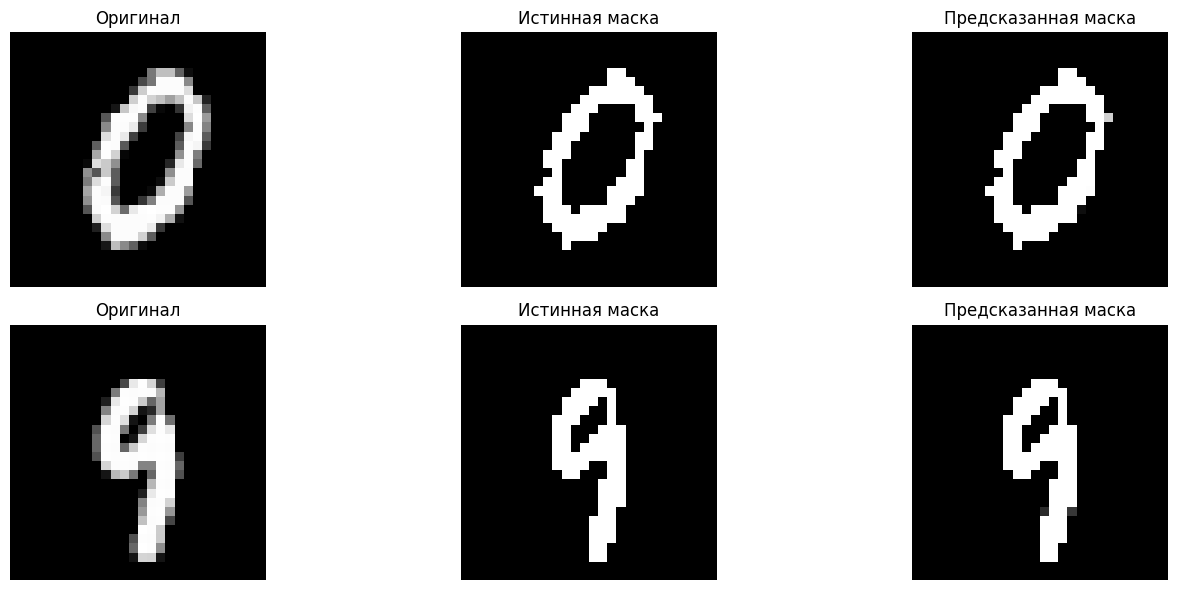

In [ ]:
# Визуализация
visualize_segmentation(predictions, x_test, y_test_masks, num_images=2)

**Сегментация изображений из датасета Oxford-IIIT Pets**
Oxford-IIIT Pet Dataset: https://www.robots.ox.ac.uk/~vgg/data/pets/
Оригинальный пример кода: https://colab.research.google.com/github/margaretmz/image-segmentation/blob/main/unet_pet_segmentation.ipynb#scrollTo=ajAbpevhSHO7

Обучение на GPU занимает 11 минут для 7 эпох.

На CPU лучше не запускать - ОЧЕНЬ ДОЛГО

Рекомендуется 20 эпох

In [ ]:
!pip install tensorflow_datasets==4.9.3
import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 26.8 MB/s eta 0:00:00
  Attempting uninstall: tensorflow_datasets
    Found existing installation: tensorflow-datasets 4.9.8
    Uninstalling tensorflow-datasets-4.9.8:
      Successfully uninstalled tensorflow-datasets-4.9.8


In [ ]:
# гиперпараметры
IMG_WIDTH = 128
IMG_HEIGHT = 128
NUM_CLASSES = 3  # Oxford Pets - 3 класса (передний план, фон, граница)
BATCH_SIZE = 32
EPOCHS = 20

In [ ]:
# Загрузка датасета средствами tensorflow
dataset, info = tfds.load('oxford_iiit_pet', with_info=True)
print(info)
#В этом датасете только три класса: передний план (питомец), фон и граница.

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteULZZJM/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteULZZJM/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_dir=PosixGPath('/tmp/tmps_hn_unrtfds'),
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=uint8),
        'species': ClassLabel

In [ ]:
print(dataset)

{'train': <_PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>, 'test': <_PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>}


In [ ]:
print(dataset["train"])

<_PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>


In [ ]:
def resize(input_image, input_mask):
    input_image = tf.image.resize(input_image, (IMG_HEIGHT, IMG_WIDTH), method="nearest")
    input_mask = tf.image.resize(input_mask, (IMG_HEIGHT, IMG_WIDTH), method="nearest")
    return input_image, input_mask

In [ ]:
def augment(input_image, input_mask):
    if tf.random.uniform(()) > 0.5:
        # Random flipping of the image and mask
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)
    return input_image, input_mask

In [ ]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1 # Маски должны начинаться с 0.  В oxford_iiit_pet маски 1, 2, 3.
    return input_image, input_mask

In [ ]:
def load_image_train(datapoint):
    input_image, input_mask = resize(datapoint['image'], datapoint['segmentation_mask'])
    input_image, input_mask = augment(input_image, input_mask)
    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask

In [ ]:
def load_image_test(datapoint):
    input_image, input_mask = resize(datapoint['image'], datapoint['segmentation_mask'])
    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask

In [ ]:
# подготовка данных
TRAIN_LENGTH = info.splits['train'].num_examples
TEST_LENGTH = info.splits['test'].num_examples

train_dataset = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = dataset['test'].map(load_image_test, num_parallel_calls=tf.data.AUTOTUNE)

train_dataset = train_dataset.cache().shuffle(TRAIN_LENGTH).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
VALIDATION_STEPS = TEST_LENGTH // BATCH_SIZE

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ["Input Image", "True Mask", "Predicted Mask"]

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis("off")
  plt.show()

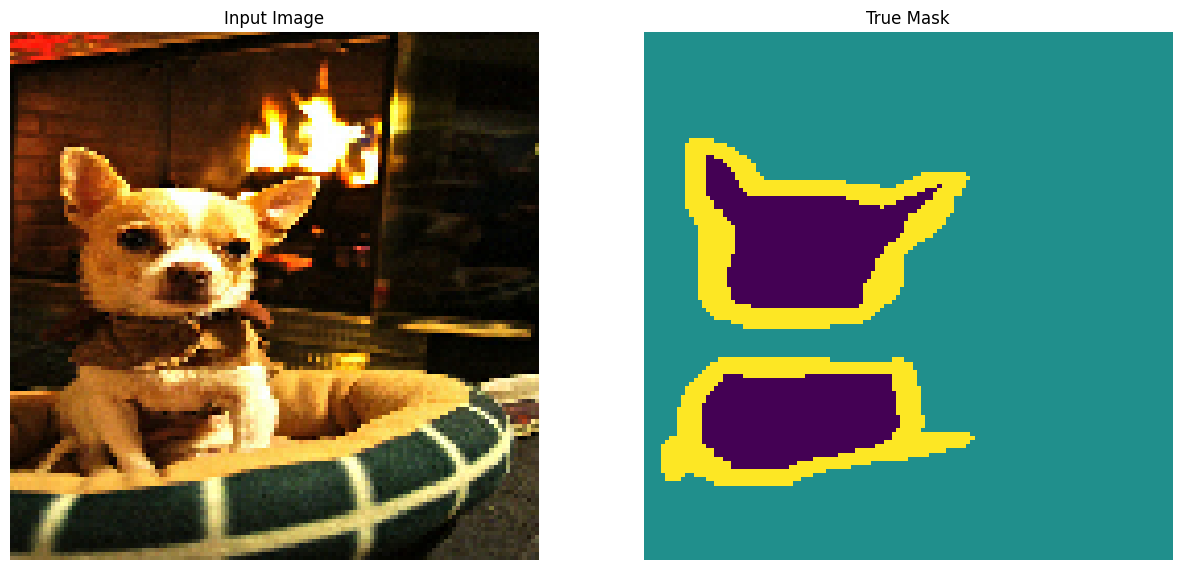

In [ ]:
sample_batch = next(iter(test_dataset))
random_index = np.random.choice(sample_batch[0].shape[0])
sample_image, sample_mask = sample_batch[0][random_index], sample_batch[1][random_index]
display([sample_image, sample_mask])

In [ ]:
# U-Net Архитектура
def build_unet(img_width, img_height, num_classes):
    inputs = tf.keras.Input(shape=(img_width, img_height, 3))

    # Encoder
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D((2, 2))(conv1)

    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D((2, 2))(conv2)

    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D((2, 2))(conv3)

    # Bottleneck
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv4)

    # Decoder
    up5 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv4)
    #merge5 = layers.concatenate([conv3, up5], axis=3)
    conv5 = layers.Conv2D(256, 3, activation='relu', padding='same')(up5)
    conv5 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv5)

    up6 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv5)
    #merge6 = layers.concatenate([conv2, up6], axis=3)
    conv6 = layers.Conv2D(128, 3, activation='relu', padding='same')(up6)
    conv6 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv6)

    up7 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv6)
    #merge7 = layers.concatenate([conv1, up7], axis=3)
    conv7 = layers.Conv2D(64, 3, activation='relu', padding='same')(up7)
    conv7 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv7)

    # Output Layer
    outputs = layers.Conv2D(num_classes, 1, activation='softmax')(conv7)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
# Определение модели, функции потерь и оптимизатора
unet_model = build_unet(IMG_WIDTH, IMG_HEIGHT, NUM_CLASSES)
unet_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', # Важно: SparseCategoricalCrossentropy и int метки
              metrics=['accuracy'])
unet_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 32, 32, 256)         │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 64, 64, 128)         │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 128, 128, 64)        │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 6,923,331 (26.41 MB)

 Trainable params: 6,923,331 (26.41 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Визуализация результатов (функции)
def display(display_list):
  plt.figure(figsize=(10, 10))
  title = ['Input Image', 'True Mask', 'Predicted Mask']
  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask

In [ ]:
def show_predictions(dataset, model, num=1): # dataset и model передаются аргументами
  for image, mask in dataset.shuffle(buffer_size=TEST_LENGTH).take(num):
    pred_mask = model.predict(image)
    display([image[0], mask[0], create_mask(pred_mask)[0]])

In [ ]:
# Custom Callback для визуализации во время обучения модели
class VisualizeSegmentation(tf.keras.callbacks.Callback):
    def __init__(self, dataset, display_every=2):
        super(VisualizeSegmentation, self).__init__()
        self.dataset = dataset
        self.display_every = display_every

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.display_every == 0:
            print(f"Generating visualizations after epoch {epoch+1}")
            show_predictions(self.dataset, self.model) # Передаем self.model

In [ ]:
# Подготовка валидационного набора для визуализации
visualization_dataset = test_dataset#.take(1)  # Берем один батч для визуализации

"""
Создан отдельный набор данных visualization_dataset для визуализации.
Это важно, потому что прямой доступ к данным внутри test_dataset после батчинга
может быть затруднен. Мы берем один батч из test_images для визуализации.
"""

'\nСоздан отдельный набор данных visualization_dataset для визуализации.\nЭто важно, потому что прямой доступ к данным внутри test_dataset после батчинга\nможет быть затруднен. Мы берем один батч из test_images для визуализации.\n'

In [ ]:
# Создание экземпляра обратного вызова
visualization_callback = VisualizeSegmentation(visualization_dataset, display_every=2)

Epoch 1/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 81s 381ms/step - accuracy: 0.5144 - loss: 0.9849 - val_accuracy: 0.6603 - val_loss: 0.8038
Epoch 2/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 0.6830 - loss: 0.7875Generating visualizations after epoch 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 781ms/step


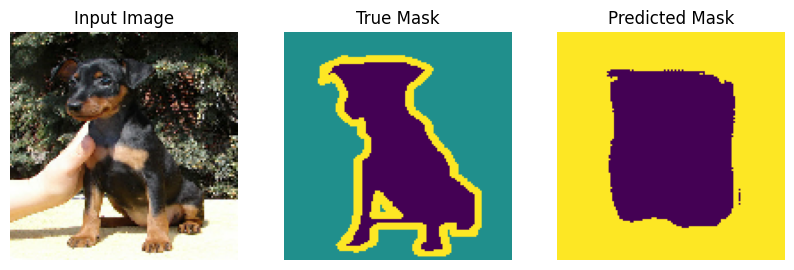

115/115 ━━━━━━━━━━━━━━━━━━━━ 60s 526ms/step - accuracy: 0.6831 - loss: 0.7873 - val_accuracy: 0.7141 - val_loss: 0.7174
Epoch 3/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 40s 348ms/step - accuracy: 0.7139 - loss: 0.7197 - val_accuracy: 0.7341 - val_loss: 0.6563
Epoch 4/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.7449 - loss: 0.6414Generating visualizations after epoch 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


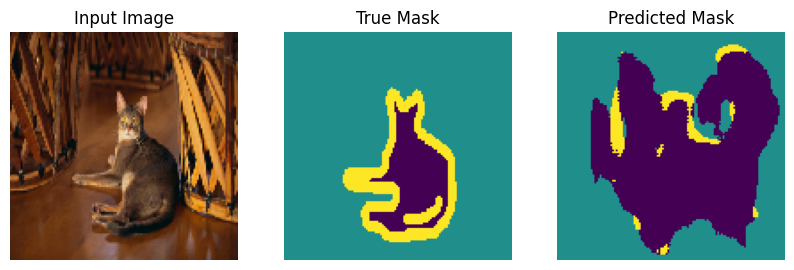

115/115 ━━━━━━━━━━━━━━━━━━━━ 51s 447ms/step - accuracy: 0.7450 - loss: 0.6413 - val_accuracy: 0.7709 - val_loss: 0.5785
Epoch 5/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 71s 625ms/step - accuracy: 0.7738 - loss: 0.5715 - val_accuracy: 0.7981 - val_loss: 0.5101
Epoch 6/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.7989 - loss: 0.5108Generating visualizations after epoch 6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


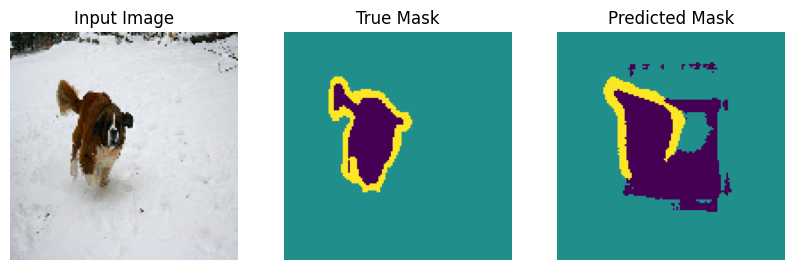

115/115 ━━━━━━━━━━━━━━━━━━━━ 52s 450ms/step - accuracy: 0.7989 - loss: 0.5107 - val_accuracy: 0.8161 - val_loss: 0.4722
Epoch 7/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 72s 629ms/step - accuracy: 0.8204 - loss: 0.4578 - val_accuracy: 0.8206 - val_loss: 0.4559
Epoch 8/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - accuracy: 0.8312 - loss: 0.4336Generating visualizations after epoch 8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


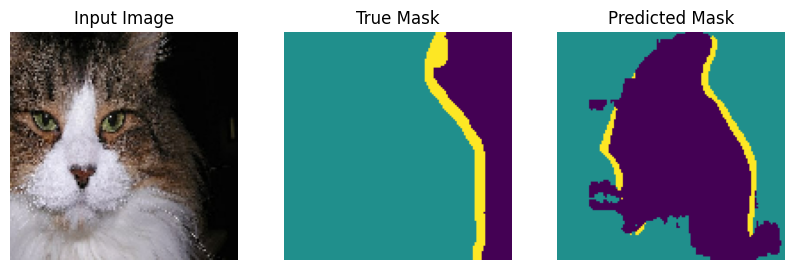

115/115 ━━━━━━━━━━━━━━━━━━━━ 92s 802ms/step - accuracy: 0.8312 - loss: 0.4335 - val_accuracy: 0.8229 - val_loss: 0.4496
Epoch 9/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 41s 356ms/step - accuracy: 0.8366 - loss: 0.4204 - val_accuracy: 0.8321 - val_loss: 0.4318
Epoch 10/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.8523 - loss: 0.3804Generating visualizations after epoch 10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


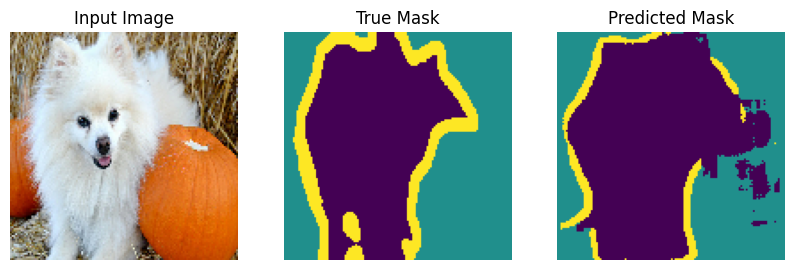

115/115 ━━━━━━━━━━━━━━━━━━━━ 92s 801ms/step - accuracy: 0.8523 - loss: 0.3804 - val_accuracy: 0.8143 - val_loss: 0.4737
Epoch 11/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 72s 628ms/step - accuracy: 0.8549 - loss: 0.3769 - val_accuracy: 0.8493 - val_loss: 0.3981
Epoch 12/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - accuracy: 0.8707 - loss: 0.3335Generating visualizations after epoch 12
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


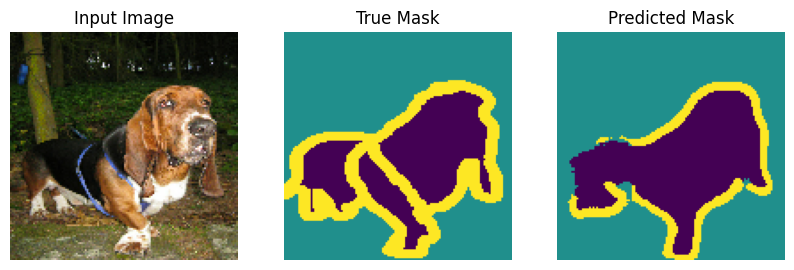

115/115 ━━━━━━━━━━━━━━━━━━━━ 51s 442ms/step - accuracy: 0.8707 - loss: 0.3336 - val_accuracy: 0.8538 - val_loss: 0.3782
Epoch 13/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 71s 624ms/step - accuracy: 0.8717 - loss: 0.3312 - val_accuracy: 0.8607 - val_loss: 0.3646
Epoch 14/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.8823 - loss: 0.3016Generating visualizations after epoch 14
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


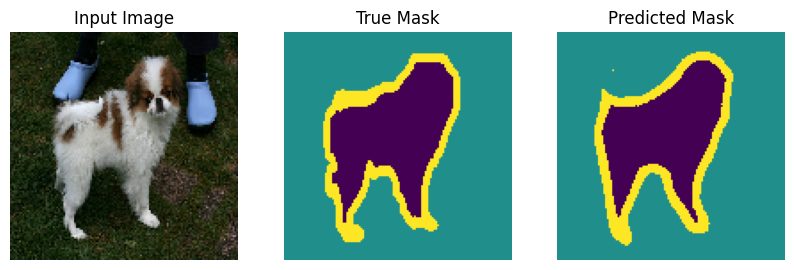

115/115 ━━━━━━━━━━━━━━━━━━━━ 51s 445ms/step - accuracy: 0.8823 - loss: 0.3016 - val_accuracy: 0.8610 - val_loss: 0.3766
Epoch 15/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 72s 626ms/step - accuracy: 0.8896 - loss: 0.2824 - val_accuracy: 0.8635 - val_loss: 0.3625
Epoch 16/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.8933 - loss: 0.2725Generating visualizations after epoch 16
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


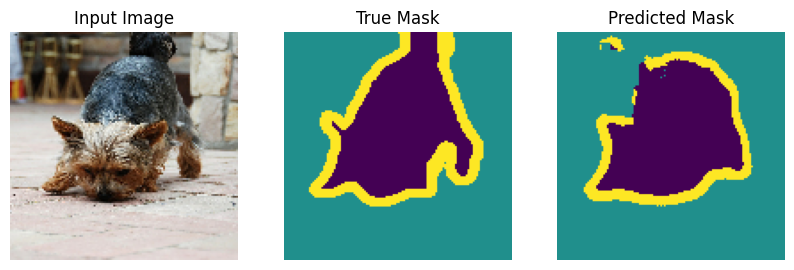

115/115 ━━━━━━━━━━━━━━━━━━━━ 51s 448ms/step - accuracy: 0.8933 - loss: 0.2724 - val_accuracy: 0.8627 - val_loss: 0.3660
Epoch 17/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 41s 361ms/step - accuracy: 0.8972 - loss: 0.2608 - val_accuracy: 0.8664 - val_loss: 0.3705
Epoch 18/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - accuracy: 0.9095 - loss: 0.2280Generating visualizations after epoch 18
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


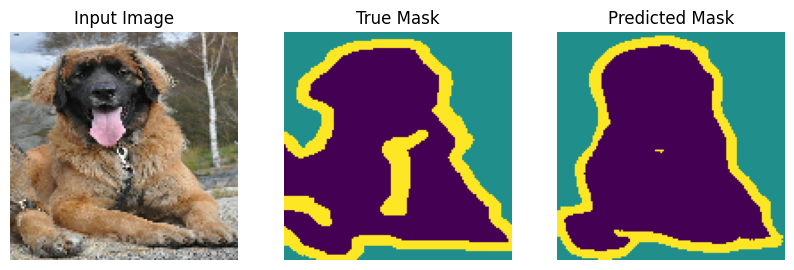

115/115 ━━━━━━━━━━━━━━━━━━━━ 52s 453ms/step - accuracy: 0.9095 - loss: 0.2280 - val_accuracy: 0.8668 - val_loss: 0.3809
Epoch 19/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 72s 624ms/step - accuracy: 0.9167 - loss: 0.2082 - val_accuracy: 0.8651 - val_loss: 0.3882
Epoch 20/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.9205 - loss: 0.1978Generating visualizations after epoch 20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


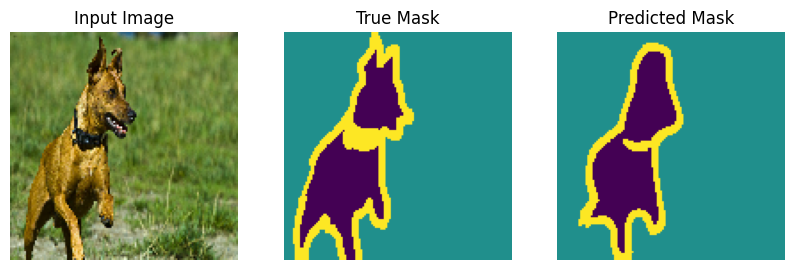

115/115 ━━━━━━━━━━━━━━━━━━━━ 51s 448ms/step - accuracy: 0.9204 - loss: 0.1978 - val_accuracy: 0.8648 - val_loss: 0.4191


In [ ]:
# Обучение модели с использованием обратного вызова
model_history = unet_model.fit(train_dataset,
                               epochs=EPOCHS,
                               steps_per_epoch=STEPS_PER_EPOCH,
                               validation_steps=VALIDATION_STEPS,
                               validation_data=test_dataset,
                               callbacks=[visualization_callback])

In [ ]:
# Оценка модели
loss, accuracy = unet_model.evaluate(test_dataset, steps=VALIDATION_STEPS)
print(f"Точность на тестовом наборе данных: {accuracy}")

114/114 ━━━━━━━━━━━━━━━━━━━━ 10s 89ms/step - accuracy: 0.8663 - loss: 0.4103
Точность на тестовом наборе данных: 0.8648431301116943


Удаление пропускных связей между путями сжатия и расширения привело к увеличению ошибки сегментации и времени обучения модели